In [26]:
import os
import zipfile

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt


In [2]:
# !wget https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
# !unzip bank+marketing.zip 
# !unzip bank.zip

In [3]:
use_cols = [
    'age',
    'job',
    'marital',
    'education',
    'balance',
    'housing',
    'contact',
    'day',
    'month',
    'duration',
    'campaign',
    'pdays',
    'previous',
    'poutcome',
    'y'
]

df =  pd.read_csv('bank-full.csv', delimiter=';', usecols=use_cols)

In [4]:
df.shape

(45211, 15)

In [5]:
df.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,no


In [6]:
df.isnull().sum()

age          0
job          0
marital      0
education    0
balance      0
housing      0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

***target encoding***

In [7]:

df['y'] = df['y'].map({'yes': 1, 'no': 0})

In [8]:
df.y.unique()

array([0, 1])

***split data***

In [9]:
SEED = 1 ## random state = 1
TRAIN_SIZE = 0.6
VAL_SIZE = 0.2
TEST_SIZE = 0.2

In [10]:
df_train_full, df_test = train_test_split(df, test_size=TEST_SIZE, shuffle=True, random_state=SEED)   

In [11]:
df_train, df_val = train_test_split(df_train_full, test_size=VAL_SIZE/(TRAIN_SIZE+VAL_SIZE), shuffle=True, random_state=SEED)   

In [12]:
df_train.shape[0] + df_val.shape[0] + df_test.shape[0] == df.shape[0]

True

In [13]:
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
df_train.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,56,entrepreneur,married,tertiary,40,no,cellular,11,jul,123,2,-1,0,unknown,0
1,33,technician,married,secondary,4790,yes,cellular,20,apr,137,1,272,2,failure,0
2,32,technician,single,tertiary,392,yes,cellular,21,nov,148,2,-1,0,unknown,0
3,40,admin.,divorced,secondary,2129,no,cellular,30,apr,452,1,-1,0,unknown,1
4,54,unemployed,married,tertiary,1180,no,cellular,19,nov,394,2,-1,0,unknown,0


In [14]:
y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

In [15]:
df_train = df_train.drop('y', axis=1)
df_val = df_val.drop('y', axis=1)
df_test = df_test.drop('y', axis=1)
df_train.head(2)

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome
0,56,entrepreneur,married,tertiary,40,no,cellular,11,jul,123,2,-1,0,unknown
1,33,technician,married,secondary,4790,yes,cellular,20,apr,137,1,272,2,failure


## ***Q1***

In [16]:
numeric_features = df_train.select_dtypes(include=[np.number]).columns.tolist()

In [17]:
# remove the target variable
numeric_features

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [18]:
corr_matrix = df_train[numeric_features].corr().abs()
corr_matrix.values[np.tri(*corr_matrix.shape, dtype=bool).T] = np.nan

In [19]:
corr_matrix

,age,balance,day,duration,campaign,pdays,previous
age,NaN,NaN,NaN,NaN,NaN,NaN,NaN
balance,0.107200,NaN,NaN,NaN,NaN,NaN,NaN
day,0.009160,0.003456,NaN,NaN,NaN,NaN,NaN
duration,0.004686,0.025840,0.031680,NaN,NaN,NaN,NaN
campaign,0.004503,0.015384,0.164946,0.081895,NaN,NaN,NaN
pdays,0.025406,0.002903,0.089005,0.006919,0.087523,NaN,NaN
previous,0.001814,0.022400,0.052384,0.003500,0.042301,0.544826,NaN


In [20]:
auc_scores = {}
for num_feat in numeric_features:
    auc = roc_auc_score(y_train, df_train[num_feat])
    if auc < 0.5:
        auc = roc_auc_score(y_train, - df_train[num_feat])
    auc_scores[num_feat] = auc

auc_scores_df = pd.DataFrame(list(auc_scores.items()), columns=['Feature', 'AUC']).sort_values(by='AUC', ascending=False)   
auc_scores_df

,Feature,AUC
3,duration,0.814700
6,previous,0.598565
5,pdays,0.590128
1,balance,0.588831
4,campaign,0.571454
2,day,0.525958
0,age,0.512186


***Q1 Answer***: duration

## ***Q2***

In [21]:
dv = DictVectorizer(sparse=False)
train_dict = df_train.to_dict(orient='records')
X_train_encoded = dv.fit_transform(train_dict)

In [22]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_encoded, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [23]:
val_dict =df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]

In [24]:
auc = np.round(roc_auc_score(y_val, y_pred), 3)
auc

np.float64(0.9)

***Q2 Answer***: 0.9

## ***Q3*** 

/var/folders/dy/hj6bz72s1c308s0hhqg7bz_80000gp/T/ipykernel_11162/2221804618.py:17: RuntimeWarning: invalid value encountered in scalar divide
  precisions.append(tp / (tp + fp))


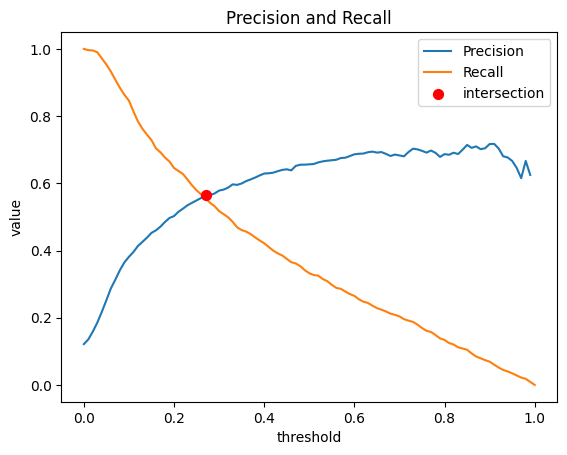

In [28]:
thresholds = np.linspace(0, 1, 101)

precisions = []
recalls = []

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (actual_positive & predict_positive).sum()
    tn = (actual_negative & predict_negative).sum()
    fp = (actual_negative & predict_positive).sum()
    fn = (actual_positive & predict_negative).sum()
    precisions.append(tp / (tp + fp))
    recalls.append(tp / (tp + fn))

df_pr = pd.DataFrame({'Precision': precisions, 'Recall': recalls}, index=thresholds)
ax = df_pr.plot(y=['Precision', 'Recall'], xlabel='threshold', ylabel='value', title='Precision and Recall')


intersection_threshold = df_pr.index.to_series().interpolate()[idx]
intersection_value = df_pr['Precision'].interpolate()[idx]
ax.scatter(intersection_threshold, intersection_value, color='red', s=50, zorder=3, label='intersection')

ax.legend()

plt.show()

***Q3 Answer:*** 0.27

## ***Q4***

In [26]:
f1_scores = 2 * (df_pr['Precision'] * df_pr['Recall']) / (df_pr['Precision'] + df_pr['Recall'])
f1_scores.idxmax()


np.float64(0.22)

***Q4 Answer:*** 0.22

## ***Q5***

In [28]:
def train(df_train_, y_train, C=1.0):
    dv = DictVectorizer(sparse=True)
    train_dict = df_train_.to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

def predict(df_val, dv, model):
    val_dict = df_val.to_dict(orient='records')
    X_val = dv.transform(val_dict)
    y_pred = model.predict(X_val)
    return y_pred

In [52]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=1)
C = 1.0
auc_scores = []

for train_idx, val_idx in kf.split(df_train_full):
    df_train_ = df_train_full.iloc[train_idx]
    df_val_ = df_train_full.iloc[val_idx]
    dv, model = train(df_train_.drop(columns='y'), df_train_.y)
    y_val = df_val_.y.values
    y_pred = predict(df_val_.drop(columns='y'), dv, model)

    auc = roc_auc_score(y_val, y_pred)

    auc_scores.append(auc)


    print(np.std(auc_scores))



0.0
0.000782241917780091
0.006436083833395974
0.005573996281869108
0.004988200940229632


***Q5 Answer:*** 0.006

## ***Q6***

In [44]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)
c_values = [0.000001, 0.001, 1]
auc_scores = []

for C in c_values:
    
    for train_idx, val_idx in kf.split(df_train_full):
        df_train_ = df_train_full.iloc[train_idx]
        df_val_ = df_train_full.iloc[val_idx]
        dv, model = train(df_train_.drop(columns='y'), df_train_.y, C=C)
        y_val = df_val_.y.values
        y_pred = predict(df_val_.drop(columns='y'), dv, model)

        auc = roc_auc_score(y_val, y_pred)

        auc_scores.append(auc)

    print(f'C={C} {np.mean(auc_scores):.3f} {np.std(auc_scores):.3f}')

C=1e-06 0.536 0.005
C=0.001 0.560 0.025
C=1 0.594 0.051


***Q6 Answer:*** 1